# Pearson's chi-squared test

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from scipy.stats import poisson
import math

# Contents of this note
## 1. Pearson's chi-squared test
## 2. Goodness of fit tests for categorical distribution
## 3. Goodness of fit tests for Poisson distribution 

# Part 1 - Pearson's chi-squared test
**[Pearson's chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) is a statistical test applied to sets of categorical data to evaluate how likely it is that any observed difference between the sets arose by chance.**


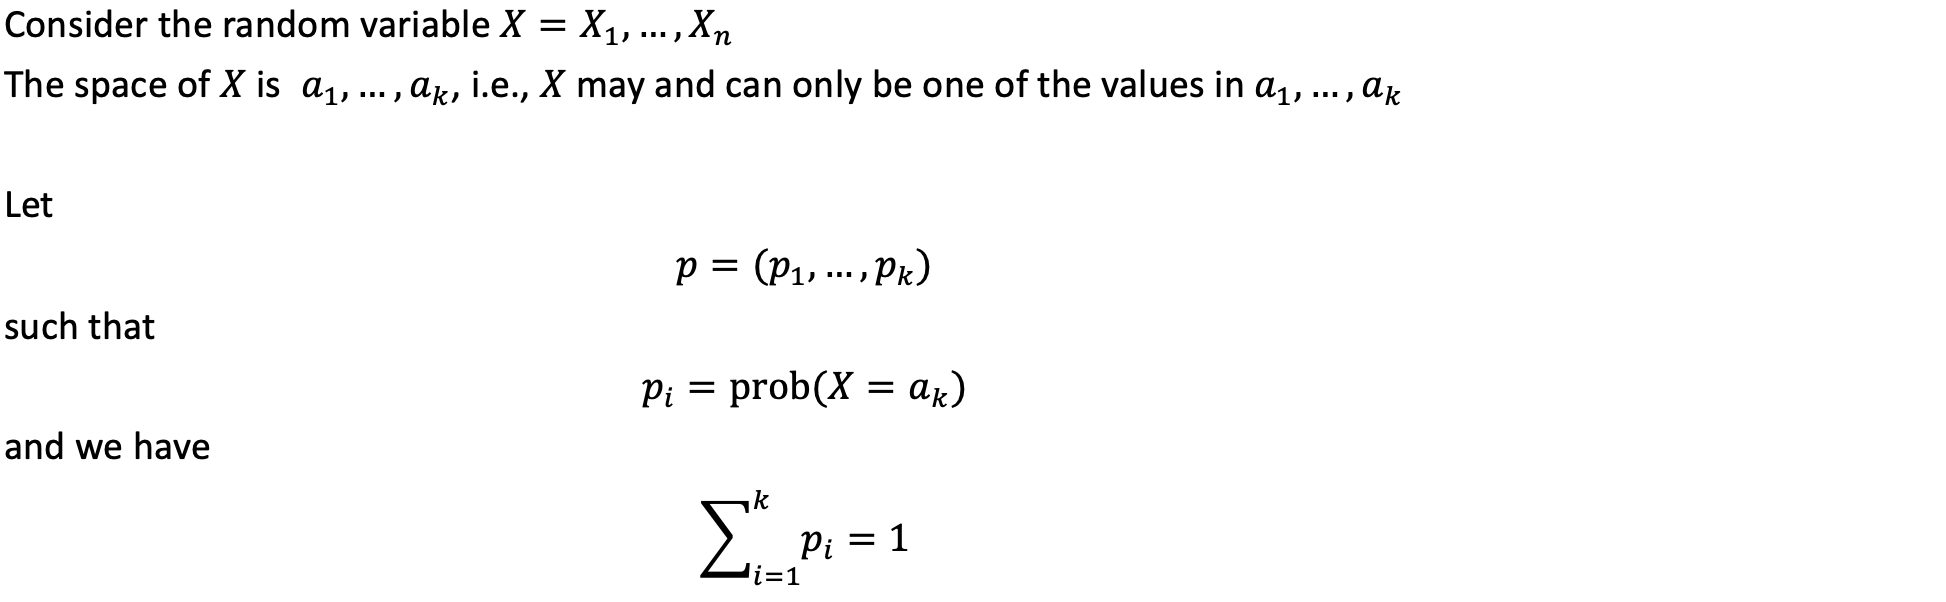

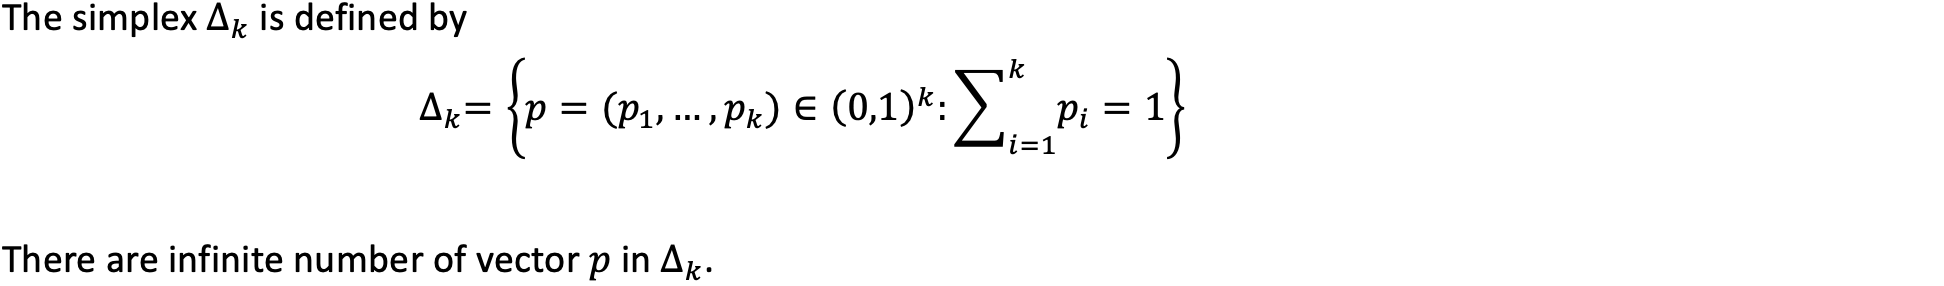

**[See examples for probability simplex here](https://github.com/houzhj/Statistics/blob/main/math/02_pearson_chi_squared_test_derivation_01.pdf)**

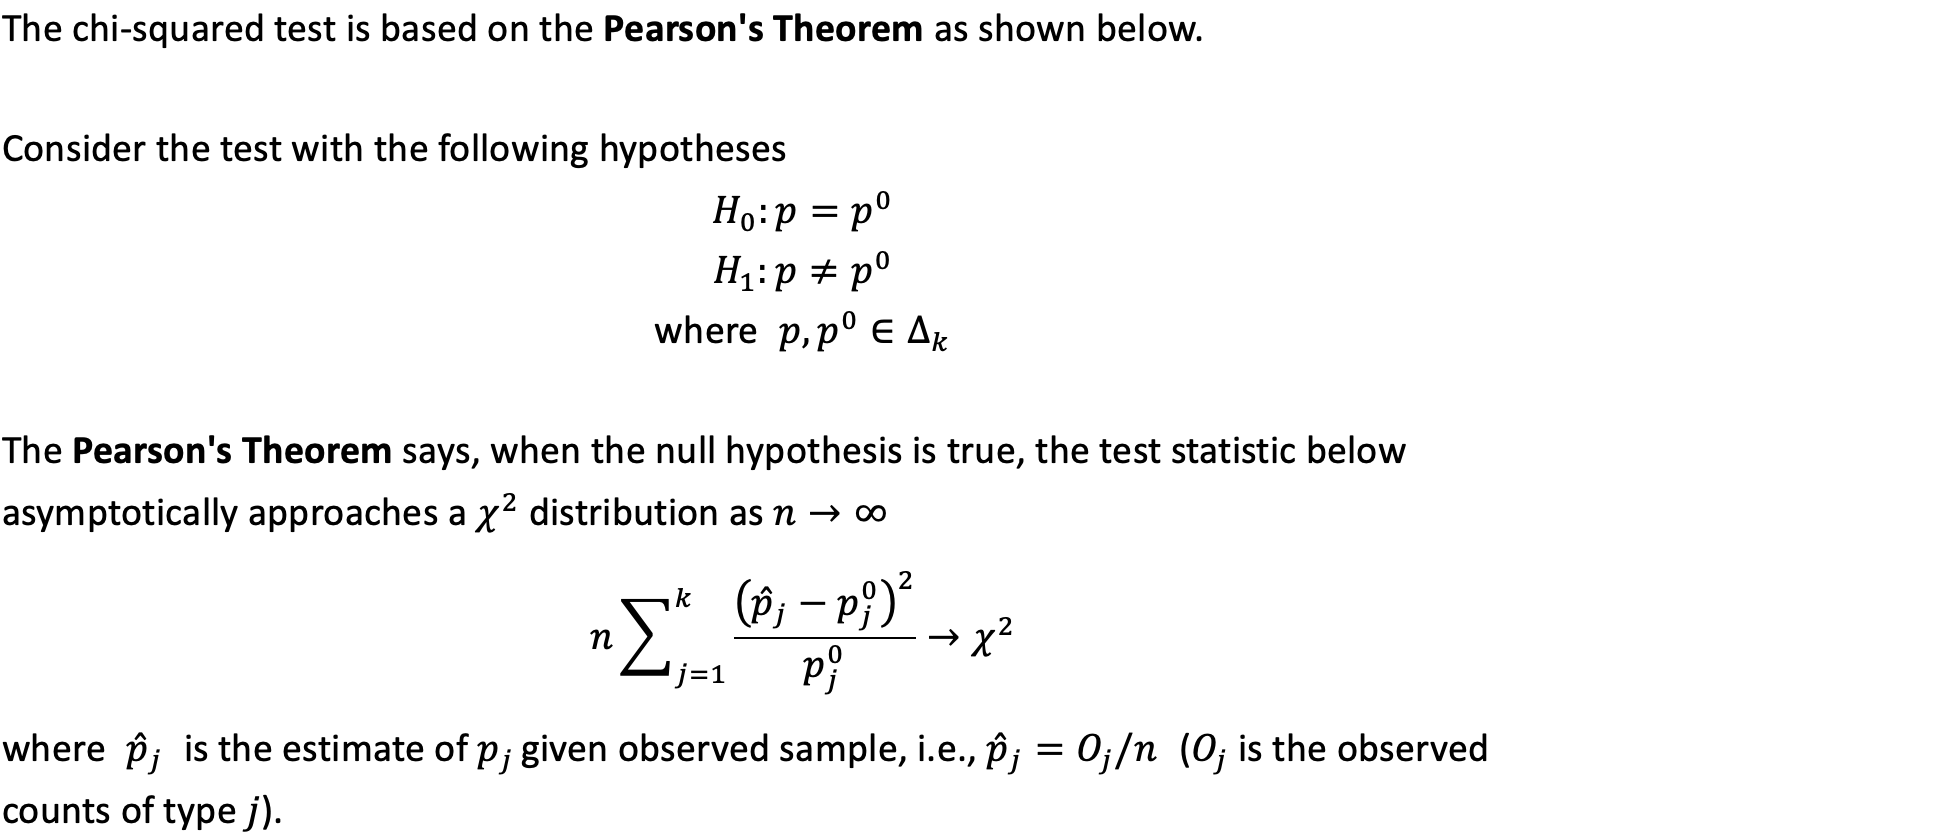

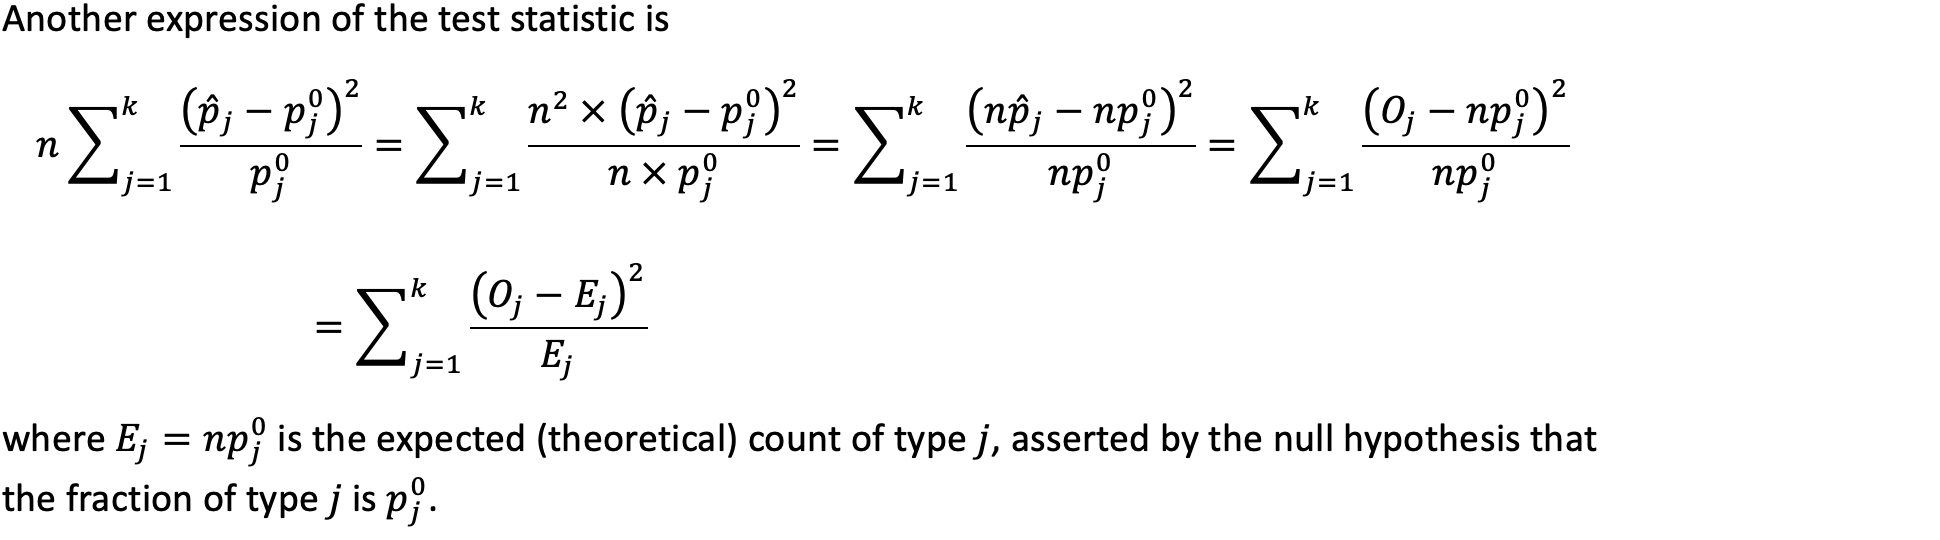

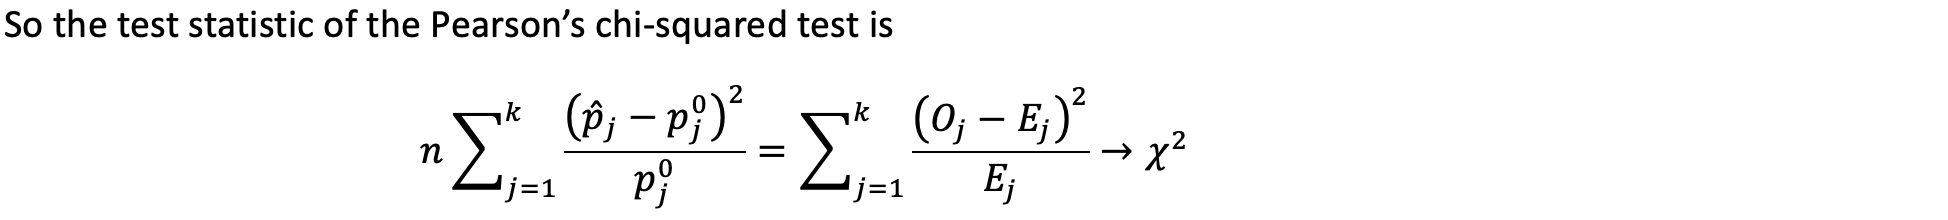

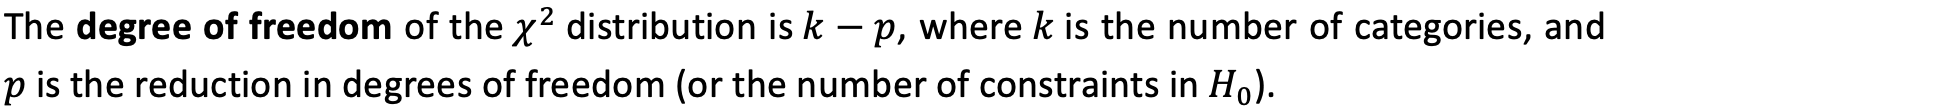

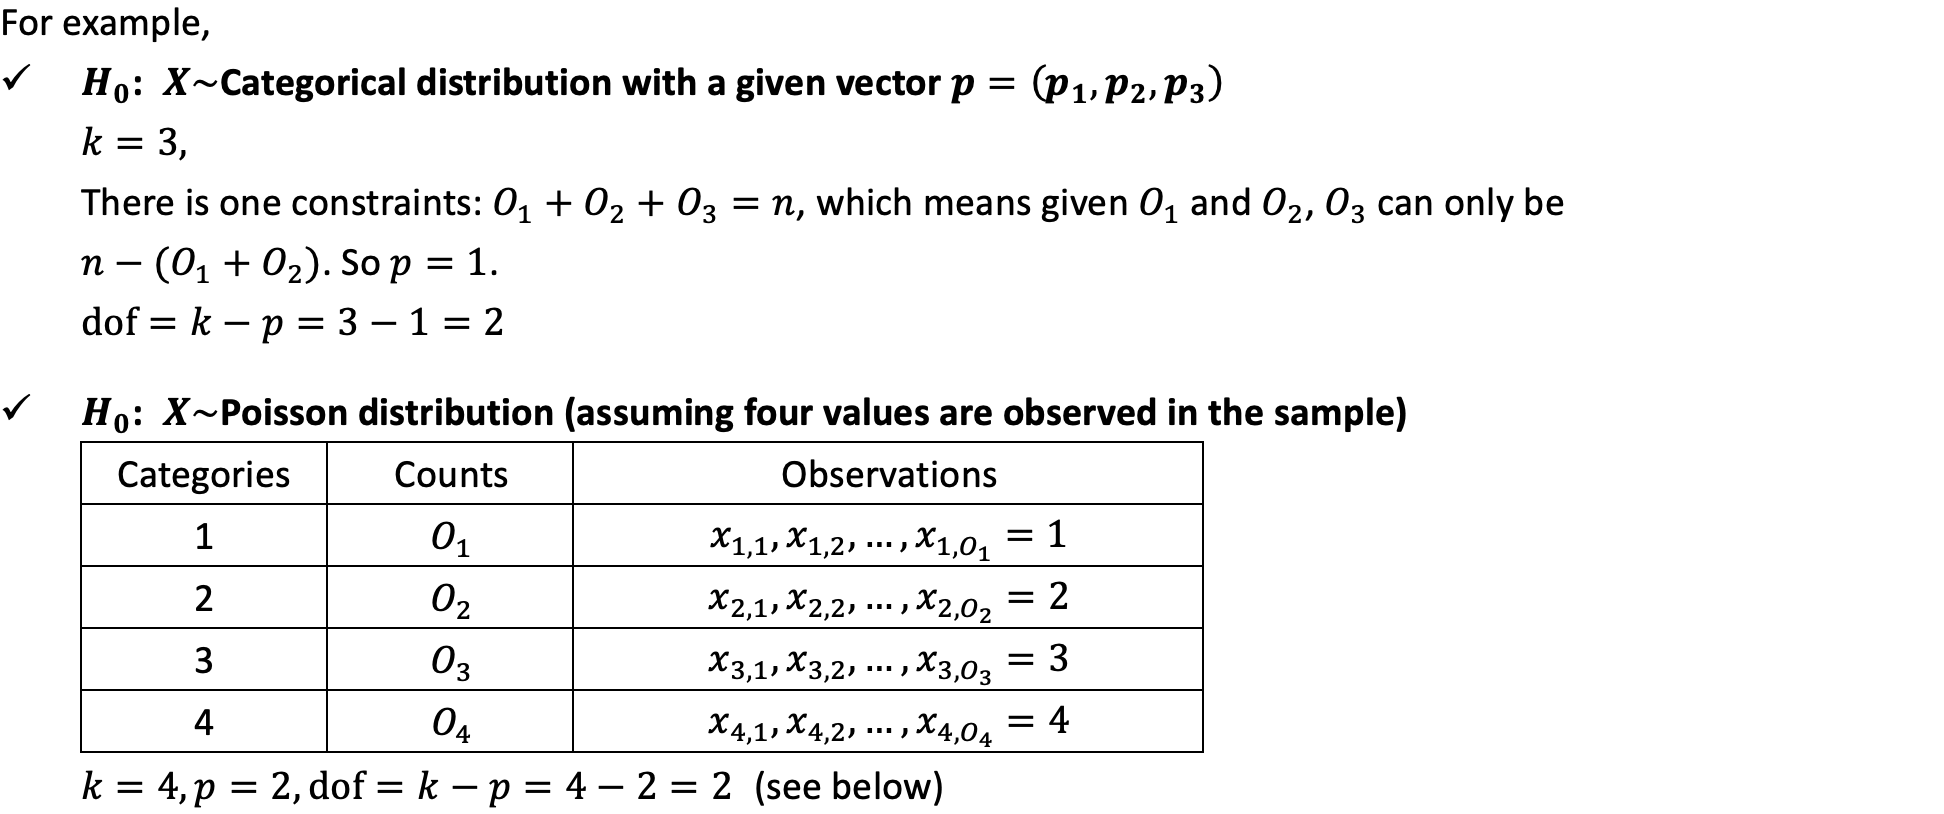

**[See discuttion about the degree of freedom in Poisson here](https://github.com/houzhj/Statistics/blob/main/math/02_pearson_chi_squared_test_derivation_02.pdf)**

# Part 2 - Goodness of fit tests for categorical distribution

### For this analysis, 
- #### Let's assume the random variable follows categorical distribution, which is known.
- #### The true distribution is a categorical distribution with the possibility vector (0.5,0.3,0.2). This is unknown.

In [2]:
### the classes
categories = ['a','b','c']

### the true probabilities, which is unknown
p_true     = [0.5,0.3,0.2]

### the sample size
sample_size = 30

### Consider the hypotheses
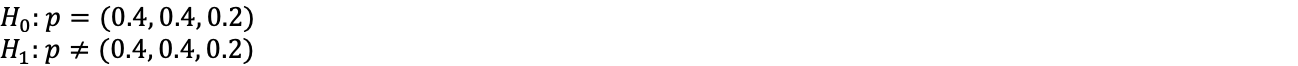

**The following codes calculate the test statistic and p-value, based on Pearson's chi-squared test.**

In [3]:
p0          = [0.4,0.4,0.2]
sample      = np.random.choice(categories,p=p_true,size=sample_size)
k           = len(p_true)
n           = len(sample) 
calc_ts     = pd.DataFrame(columns=['k','category','O','E']) 
for i in range(k):
    calc_ts.loc[i,'k']        = i
    calc_ts.loc[i,'category'] = categories[i]
    calc_ts.loc[i,'O']        = sum(sample==categories[i])
    calc_ts.loc[i,'E']        = n*p0[i]
    calc_ts.loc[i,'ts']       = (calc_ts.loc[i,'O']-calc_ts.loc[i,'E'])**2/calc_ts.loc[i,'E']
ts  = calc_ts['ts'].sum()
dof = k - 1
p   = 1-stats.chi2.cdf(ts, dof)

In [4]:
print('P-value:' + str(round(p,5)))

P-value:0.23262


### Transfer the codes above to a function, with three parameters. Again, the categorical values are 'a','b','c'.
#### (1) true possibility vector  
#### (2) possibility vector in the null hypothesis,
#### (3) sample size.  

In [5]:
def chisquared_categorical(p_true,p0,sample_size):
    if (np.sum(p_true)!=1 or np.sum(p0)!=1):
        return('invalid input')
    categories  = ['a','b','c']
    sample      = np.random.choice(categories,p=p_true,size=sample_size)
    k           = len(p_true)
    n           = sample_size
    calc_ts     = pd.DataFrame(columns=['k','category','O','E']) 
    for i in range(k):
        calc_ts.loc[i,'k']        = i
        calc_ts.loc[i,'category'] = categories[i]
        calc_ts.loc[i,'O']        = sum(sample==categories[i])
        calc_ts.loc[i,'E']        = n*p0[i]
        calc_ts.loc[i,'ts']       = (calc_ts.loc[i,'O']-calc_ts.loc[i,'E'])**2/calc_ts.loc[i,'E']
    ts  = calc_ts['ts'].sum()
    dof = k - 1
    p   = 1-stats.chi2.cdf(ts, dof)
    return(ts,p,calc_ts)

### The function below conducts 1000 experiments of the chisquared_categorical() function.
- #### The output is a dataframe stores the results of the experiment. 
- #### Using this dataframe we can calculate the Type 1 error rate (if p_true=p0) or Type 2 Error Rate.

In [6]:
def chisquared_categorical_experiment(p_true,p0,sample_size,n_experiment=1000):
    if (np.sum(p_true)!=1 or np.sum(p0)!=1):
        return('invalid input')
    alpha        = 0.05
    results      = pd.DataFrame(columns =['ts','p','reject','sample_size'])
    for e in range(n_experiment):
        ts,p,calc_ts = chisquared_categorical(p_true,p0,sample_size)
        results.loc[e,'ts']     = ts
        results.loc[e,'p']      = p
        results.loc[e,'reject'] = int(p<alpha)
    if (p_true==p0):
        results['type_1_error'] = results['reject']
    else:
        results['type_2_error'] = 1-results['reject']
    results['sample_size'] = sample_size
    return(results)
    

In [7]:
p_true = [1/3,1/3,1/3]
p0     = [0.5,0.3,0.2]

In [8]:
chisquared_categorical_experiment(p_true=p_true,p0=p0,sample_size=10)

,ts,p,reject,sample_size,type_2_error
0,1.633333,0.441902,0,10,1
1,0.533333,0.765928,0,10,1
2,0.533333,0.765928,0,10,1
3,0.533333,0.765928,0,10,1
4,0.7,0.704688,0,10,1
...,...,...,...,...,...
995,10.133333,0.006303,1,10,0
996,8.033333,0.018013,1,10,0
997,8.533333,0.014028,1,10,0
998,10.133333,0.006303,1,10,0


### Example 1: False null hypothesis
#### H0: [0.5,0.3,0.2]
#### True: [1/3, 1/3. 1/3]

In [9]:
chisquared_categorical_10  = chisquared_categorical_experiment(p_true=p_true,p0=p0,sample_size=10)
chisquared_categorical_50  = chisquared_categorical_experiment(p_true=p_true,p0=p0,sample_size=50)
chisquared_categorical_100 = chisquared_categorical_experiment(p_true=p_true,p0=p0,sample_size=100)
chisquared_categorical_200 = chisquared_categorical_experiment(p_true=p_true,p0=p0,sample_size=200)
chisquared_categorical_all = pd.concat([chisquared_categorical_10,
                                        chisquared_categorical_50,
                                        chisquared_categorical_100,
                                        chisquared_categorical_200],axis=0)
chisquared_categorical_all.groupby('sample_size')['type_2_error'].mean().reset_index()

,sample_size,type_2_error
0,10,0.778
1,50,0.343
2,100,0.066
3,200,0.003


**For these particular hypotheses, the Type 2 Error rate decreases as the sample size increases.**

### Example 2: True null hypothesis
#### H0: [1/3, 1/3. 1/3]
#### True: [1/3, 1/3. 1/3]

In [10]:
chisquared_categorical_10  = chisquared_categorical_experiment(p_true=p_true,p0=p_true,sample_size=10)
chisquared_categorical_50  = chisquared_categorical_experiment(p_true=p_true,p0=p_true,sample_size=50)
chisquared_categorical_100 = chisquared_categorical_experiment(p_true=p_true,p0=p_true,sample_size=100)
chisquared_categorical_200 = chisquared_categorical_experiment(p_true=p_true,p0=p_true,sample_size=200)
chisquared_categorical_all = pd.concat([chisquared_categorical_10,
                                        chisquared_categorical_50,
                                        chisquared_categorical_100,
                                        chisquared_categorical_200],axis=0)
chisquared_categorical_all.groupby('sample_size')['type_1_error'].mean().reset_index()

,sample_size,type_1_error
0,10,0.048
1,50,0.038
2,100,0.066
3,200,0.044


**For these particular hypotheses, the Type 1 Error rate are all aroung 5%.**

# Part 3 - Goodness of fit tests for Poisson Distribution

### For a random variable that follows Poisson distribution, the support of the variable is all the natural numbers. There is an option to combine some groups. The function below creates the frequency table for a given data.
- #### If the parameter "values" is None, the function uses the actual unique values as the categories. 
- #### If the "values" is a given (a list), the values will be used. The purpose of this parameter is to combine some values, such as all the intergers >=9 are included in one groups. For example, if values = [0,1,2,...,n], all the observations >=n will be classified in the same group. 

In [11]:
def get_freq_table(data,values):
    categories  = list(np.sort(np.unique(sample)))
    freq_table  = pd.DataFrame(columns = ['categories','count'])
    if values is None:
        values = np.sort(np.unique(sample)) 
        for v in range(len(values)):
            freq_table.loc[v,'categories'] = values[v]
            freq_table.loc[v,'count']      = sum(data==values[v])
    else:
        for v in range(len(values)-1):
            freq_table.loc[v,'categories'] = values[v]
            freq_table.loc[v,'count']      = sum(data==values[v])
        freq_table.loc[len(values)-1,'categories'] = values[len(values)-1]
        freq_table.loc[len(values)-1,'count']      = sum(data>=values[len(values)-1])
    return freq_table

- The list [0,1,2,3,4] is used as "values". Note that the last row, where categories = 6 is for all the integers >=6, although it shows "6" only.
- There are options of combing small value groups, or conducting more flexible grouping, but not considered here. 

In [12]:
sample = np.random.poisson(4,size=200)
get_freq_table(data=sample,values=[0,1,2,3,4])

,categories,count
0,0,3
1,1,15
2,2,38
3,3,39
4,4,105


- No specifed "values" list, so the function creates one group for every values observed in the sample. It can be seen that the counts in groups of largest (and smallest) values are small. 

In [13]:
get_freq_table(data=sample,values=None)

,categories,count
0,0,3
1,1,15
2,2,38
3,3,39
4,4,39
5,5,22
6,6,22
7,7,14
8,8,6
9,9,1


### For this analysis, let's assume our interest is whether the random variable follows a Poisson distribution. 
- #### This is unlike the example above, in which we are aware that the distribution is a Categorical distribution and the test is whether the possibilities are some particualr values.
- #### If our interest is about the value of parameter lambda in a Poisson distribution, given that the random variable follows a Poisson distribution, we can use a Wald test or a likelihood ratio test instead. [See discussions in this notebook.](https://github.com/houzhj/Statistics/blob/main/ipynb/02_wald_lr_test.ipynb)

### Assume the true distribution is a Poisson(4) distribution. The null hypothesis is that the distribution of the variable is Poisson distribution (i.e., the null hypothesis is True). 

In [14]:
lambda_true = 4

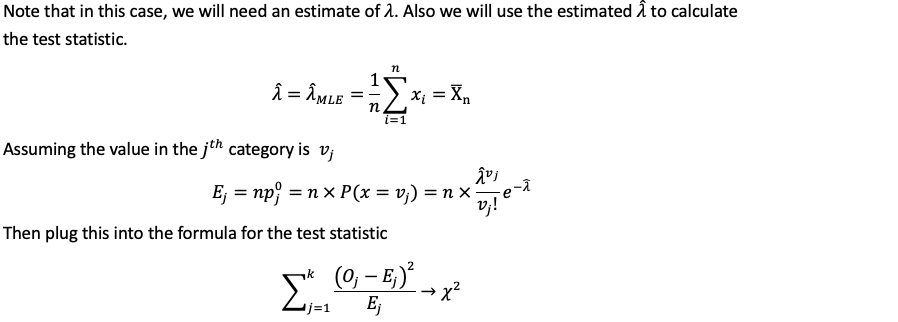

#### The codes below calculate the test statistic and the p value without combining any class

In [15]:
sample_size = 50
sample      = np.sort(np.random.poisson(lambda_true,size=sample_size))
calc_ts     = get_freq_table(data=sample,values=None) 
calc_ts['product'] = calc_ts['categories']*calc_ts['count']
lambda_mle         = calc_ts['product'].sum() / sample_size
calc_ts['O']       = calc_ts['count']

for i in range(len(calc_ts)-1):
    ## The two line below are equivalent. We use the first one
    ## (1) poisson.pmf(k,Lambda)
    ## (2) (math.exp(-Lambda)*Lambda**k) / math.factorial(k)
    calc_ts.loc[i,'E'] = poisson.pmf(calc_ts.loc[i,'categories'],lambda_mle)*sample_size
    calc_ts.loc[len(calc_ts)-1,'E'] = sample_size-calc_ts.loc[:len(calc_ts)-2,'E'].sum()

calc_ts['ts'] = (calc_ts['O']-calc_ts['E'])**2/calc_ts['E']
ts = calc_ts['ts'].sum()

k   = len(calc_ts)
dof = k - 2
p   = 1-stats.chi2.cdf(ts, dof)

In [16]:
print('P-value:' + str(round(p,5)))

P-value:0.0518


#### The codes below we used a pre-specified list of values, and combined some classes.

In [17]:
sample_size = 50
sample      = np.sort(np.random.poisson(lambda_true,size=sample_size))
values      = [0,1,2,3,4,5,6,7] 
calc_ts     = get_freq_table(data=sample,values=values) 
calc_ts['product'] = calc_ts['categories']*calc_ts['count']
lambda_mle         = calc_ts['product'].sum() / sample_size
calc_ts['O']       = calc_ts['count']

for i in range(len(calc_ts)-1):
    ## The two line below are equivalent. We use the first one
    ## (1) poisson.pmf(k,Lambda)
    ## (2) (math.exp(-Lambda)*Lambda**k) / math.factorial(k)
    calc_ts.loc[i,'E'] = poisson.pmf(calc_ts.loc[i,'categories'],lambda_mle)*sample_size

    calc_ts.loc[len(calc_ts)-1,'E'] = sample_size-calc_ts.loc[:len(calc_ts)-2,'E'].sum()
calc_ts['ts'] = (calc_ts['O']-calc_ts['E'])**2/calc_ts['E']
ts  = calc_ts['ts'].sum()
k   = len(calc_ts)
dof = k - 2
p   = 1-stats.chi2.cdf(ts, dof)

In [18]:
print('P-value:' + str(round(p,5)))

P-value:0.0241


#### Transfer the codes above to a function, with two parameters: 
- (1) whether combined classes, if yes, a list will be given
- (2) sample size. 

#### Assume the true distribution is Poisson(4). 
#### We only consider the H0: X~Poisson, i.e., we focus on Type 1 error. 

In [19]:
def chisquared_poisson(sample_size,combine_groups):
    sample = np.sort(np.random.poisson(4,size=sample_size))
    if combine_groups == 'yes':
        calc_ts = get_freq_table(data=sample,values=None) 
    else:
        calc_ts = get_freq_table(data=sample,values=[0,1,2,3,4,5,6,7,8,9])
    
    calc_ts['product'] = calc_ts['categories']*calc_ts['count']
    lambda_mle         = calc_ts['product'].sum() / sample_size
    calc_ts['O']       = calc_ts['count']  
    
    for i in range(len(calc_ts)-1):
        ## The two line below are equivalent. We use the first one
        ## (1) poisson.pmf(k,Lambda)
        ## (2) (math.exp(-Lambda)*Lambda**k) / math.factorial(k)
        calc_ts.loc[i,'E'] = poisson.pmf(calc_ts.loc[i,'categories'],lambda_mle)*sample_size

        calc_ts.loc[len(calc_ts)-1,'E'] = sample_size-calc_ts.loc[:len(calc_ts)-2,'E'].sum()
    
    calc_ts['ts'] = (calc_ts['O']-calc_ts['E'])**2/calc_ts['E']
    ts  = calc_ts['ts'].sum()
    k   = len(calc_ts)
    dof = k - 2
    p   = 1-stats.chi2.cdf(ts, dof)
    return(ts,p,calc_ts)
    

### The function below conducts 1000 experiments of the chisquared_poisson() function.
#### - The output is a dataframe stores the results of the experiment.¶
#### - Using this dataframe we can calculate the Type 1 error rate.

In [20]:
def chisquared_poisson_experiment(sample_size,combine_groups,n_experiment=1000):
    alpha        = 0.05
    results      = pd.DataFrame(columns =['ts','p','reject','sample_size'])
    for e in range(n_experiment):
        ts,p,calc_ts = chisquared_poisson(sample_size,combine_groups)
        results.loc[e,'ts']     = ts
        results.loc[e,'p']      = p
        results.loc[e,'reject'] = int(p<alpha)
    
    results['type_1_error']   = results['reject']
    results['sample_size']    = sample_size
    results['combine_groups'] = combine_groups
    return(results)

In [21]:
chisquared_poisson_10_c   = chisquared_poisson_experiment(sample_size=10,combine_groups='yes')
chisquared_poisson_50_c   = chisquared_poisson_experiment(sample_size=50,combine_groups='yes')
chisquared_poisson_100_c  = chisquared_poisson_experiment(sample_size=100,combine_groups='yes')
chisquared_poisson_200_c  = chisquared_poisson_experiment(sample_size=200,combine_groups='yes')
chisquared_poisson_500_c  = chisquared_poisson_experiment(sample_size=500,combine_groups='yes')

chisquared_poisson_10_nc  = chisquared_poisson_experiment(sample_size=10,combine_groups='no')
chisquared_poisson_50_nc  = chisquared_poisson_experiment(sample_size=50,combine_groups='no')
chisquared_poisson_100_nc = chisquared_poisson_experiment(sample_size=100,combine_groups='no')
chisquared_poisson_200_nc = chisquared_poisson_experiment(sample_size=200,combine_groups='no')
chisquared_poisson_500_nc  = chisquared_poisson_experiment(sample_size=500,combine_groups='no')

chisquared_poisson_all = pd.concat([chisquared_poisson_10_c,
                                    chisquared_poisson_50_c,
                                    chisquared_poisson_100_c,
                                    chisquared_poisson_200_c,
                                    chisquared_poisson_500_c,
                                    chisquared_poisson_10_nc,
                                    chisquared_poisson_50_nc,
                                    chisquared_poisson_100_nc,
                                    chisquared_poisson_200_nc,
                                    chisquared_poisson_500_nc],axis=0)
chisquared_poisson_all.groupby(['combine_groups','sample_size'])['type_1_error'].mean().reset_index()

,combine_groups,sample_size,type_1_error
0,no,10,0.047
1,no,50,0.039
2,no,100,0.053
3,no,200,0.041
4,no,500,0.049
5,yes,10,0.045
6,yes,50,0.043
7,yes,100,0.039
8,yes,200,0.060
9,yes,500,0.109


**Combining some classes does not necessarily decrease the Type 1 Error rate of the tests. The grouping matters.**